In [20]:
import pandas as pd
from datetime import datetime
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt
from tensorflow.keras.metrics import MeanAbsoluteError, RootMeanSquaredError

In [21]:
data = pd.read_csv('london_weather.csv')

# Преобразование даты
data['date'] = pd.to_datetime(data['date'], format='%Y%m%d')

# Заполнение пропущенных значений нулями
data.fillna(0, inplace=True)

# Преобразование остальных данных в числовой формат
for column in data.columns:
    if column != 'date':
        data[column] = pd.to_numeric(data[column])


In [22]:
print(data.head())

        date  cloud_cover  sunshine  global_radiation  max_temp  mean_temp  \
0 1979-01-01          2.0       7.0              52.0       2.3       -4.1   
1 1979-01-02          6.0       1.7              27.0       1.6       -2.6   
2 1979-01-03          5.0       0.0              13.0       1.3       -2.8   
3 1979-01-04          8.0       0.0              13.0      -0.3       -2.6   
4 1979-01-05          6.0       2.0              29.0       5.6       -0.8   

   min_temp  precipitation  pressure  snow_depth  
0      -7.5            0.4  101900.0         9.0  
1      -7.5            0.0  102530.0         8.0  
2      -7.2            0.0  102050.0         4.0  
3      -6.5            0.0  100840.0         2.0  
4      -1.4            0.0  102250.0         1.0  


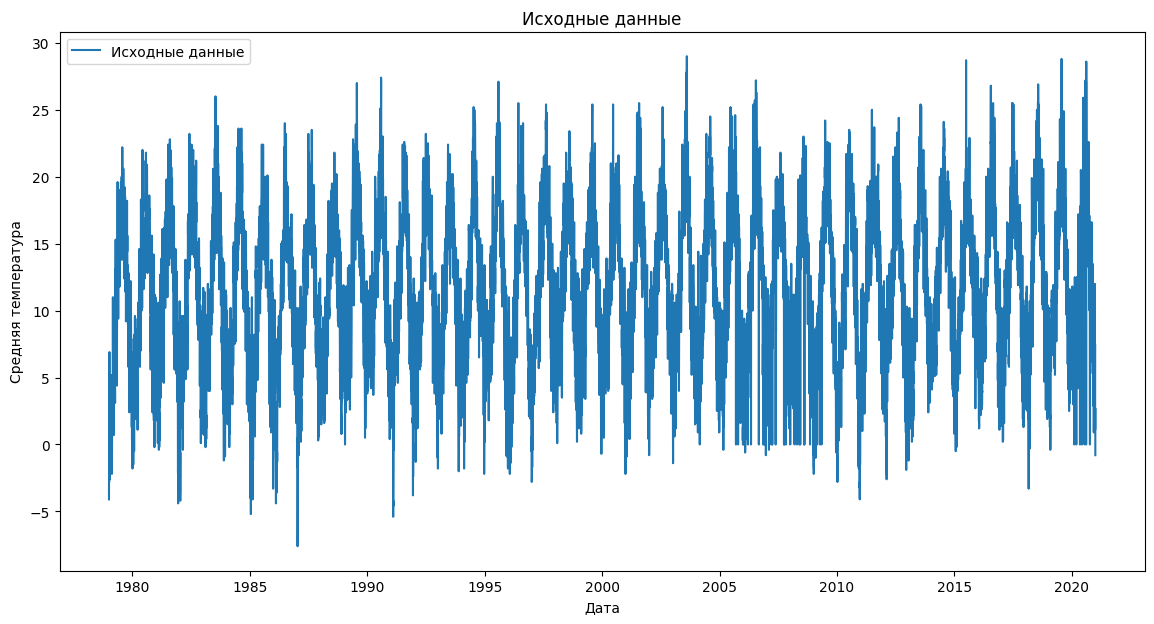

In [23]:
# График исходных данных
plt.figure(figsize=(14, 7))
plt.plot(data['date'].iloc[:], data['mean_temp'].iloc[:], label='Исходные данные')
plt.title('Исходные данные')
plt.xlabel('Дата')
plt.ylabel('Средняя температура')
plt.legend()
plt.show()

In [24]:
#  Нормализация данных
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data.drop(columns=['date']))

# Создание последовательностей
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data)-seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

SEQ_LENGTH = 30  # Длина последовательности (например, 30 дней)
X, y = create_sequences(scaled_data, SEQ_LENGTH)

# Разделение на обучающую и тестовую выборки
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]


In [25]:
# Построение модели LSTM
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(SEQ_LENGTH, X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=y_train.shape[1]))

# Компиляция модели
model.compile(optimizer='adam', loss='mean_squared_error', metrics=[MeanAbsoluteError(), RootMeanSquaredError()])

c:\Users\Sonya Hornygold\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [26]:
# Обучение модели
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/20
383/383 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - loss: 0.0480 - mean_absolute_error: 0.1539 - root_mean_squared_error: 0.2108 - val_loss: 0.0175 - val_mean_absolute_error: 0.0844 - val_root_mean_squared_error: 0.1324
Epoch 2/20
383/383 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - loss: 0.0192 - mean_absolute_error: 0.0989 - root_mean_squared_error: 0.1387 - val_loss: 0.0162 - val_mean_absolute_error: 0.0794 - val_root_mean_squared_error: 0.1275
Epoch 3/20
383/383 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - loss: 0.0172 - mean_absolute_error: 0.0913 - root_mean_squared_error: 0.1312 - val_loss: 0.0161 - val_mean_absolute_error: 0.0797 - val_root_mean_squared_error: 0.1268
Epoch 4/20
383/383 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - loss: 0.0158 - mean_absolute_error: 0.0860 - root_mean_squared_error: 0.1258 - val_loss: 0.0149 - val_mean_absolute_error: 0.0757 - val_root_mean_squared_error: 0.1219
Epoch 5/20
383/383 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - loss: 0.0149 - mean_absolute_error: 0.0820 - root_mea

96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


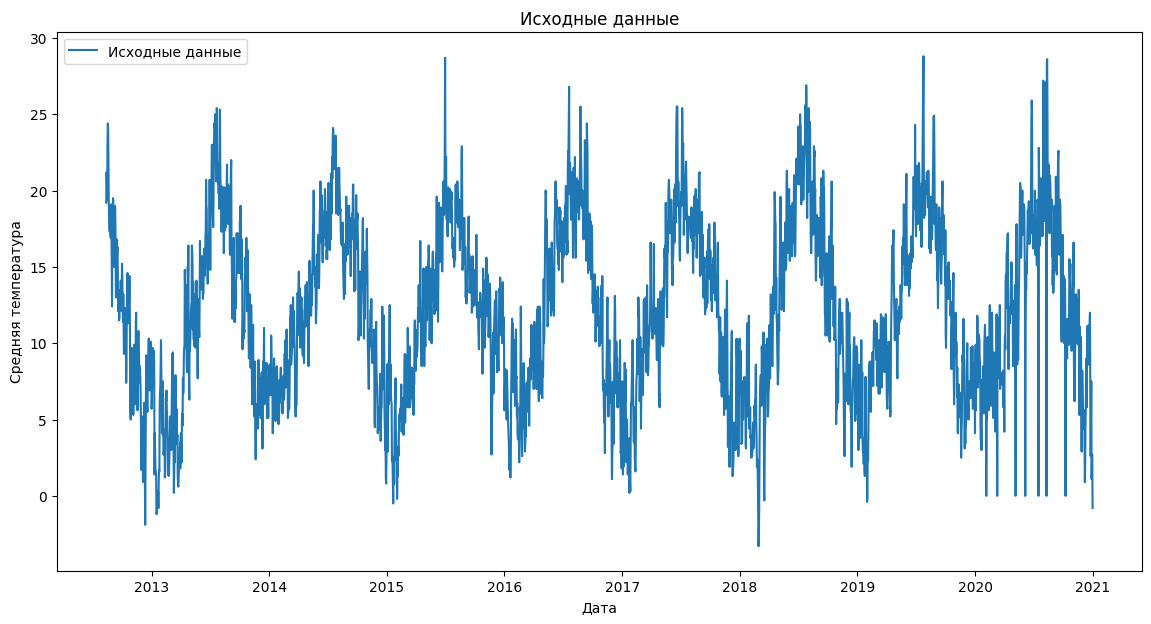

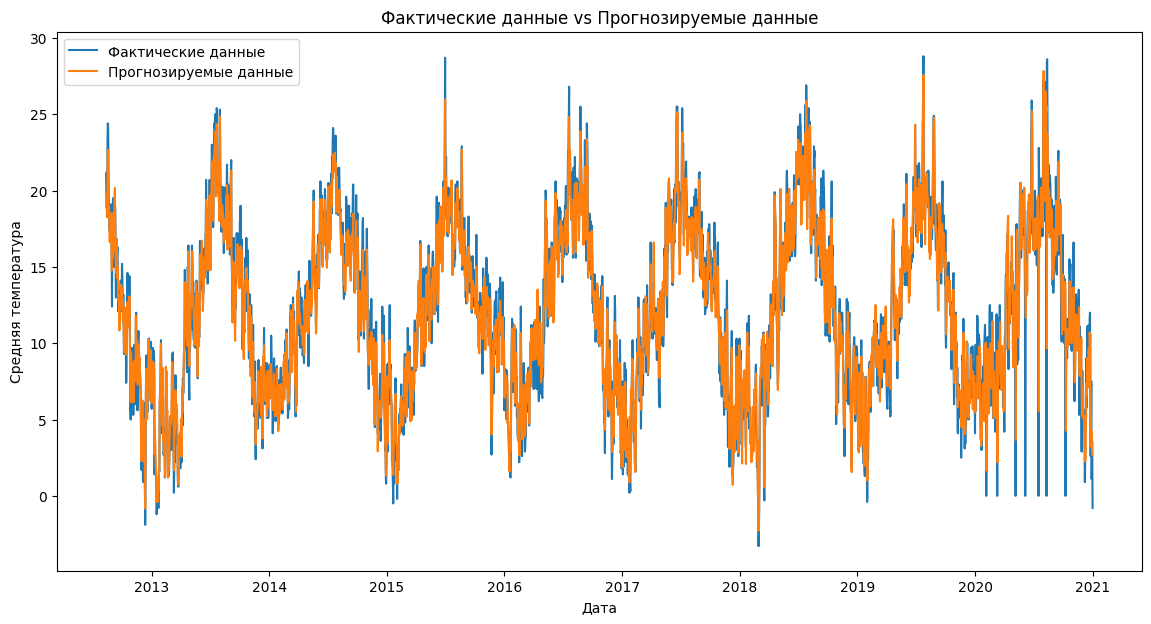

In [27]:
# Прогнозирование значений
predictions = model.predict(X_test)

# Обратное преобразование данных для предсказаний
scaled_test_data = scaled_data[-len(y_test):]
y_test_rescaled = scaler.inverse_transform(np.hstack((y_test, np.zeros((y_test.shape[0], scaled_data.shape[1] - y_test.shape[1])))))
predictions_rescaled = scaler.inverse_transform(np.hstack((predictions, np.zeros((predictions.shape[0], scaled_data.shape[1] - predictions.shape[1])))))


plt.figure(figsize=(14, 7))
plt.plot(data['date'].iloc[-len(scaled_test_data):], data['mean_temp'].iloc[-len(scaled_test_data):], label='Исходные данные')
plt.title('Исходные данные')
plt.xlabel('Дата')
plt.ylabel('Средняя температура')
plt.legend()
plt.show()

# График прогнозируемых данных vs Фактические данные (например, последние 60 дней)
plt.figure(figsize=(14, 7))
plt.plot(data['date'].iloc[-len(y_test_rescaled):], y_test_rescaled[:, data.columns.get_loc('mean_temp') - 1], label='Фактические данные')
plt.plot(data['date'].iloc[-len(predictions_rescaled):], predictions_rescaled[:, data.columns.get_loc('mean_temp') - 1], label='Прогнозируемые данные')
plt.title('Фактические данные vs Прогнозируемые данные')
plt.xlabel('Дата')
plt.ylabel('Средняя температура')
plt.legend()
plt.show()


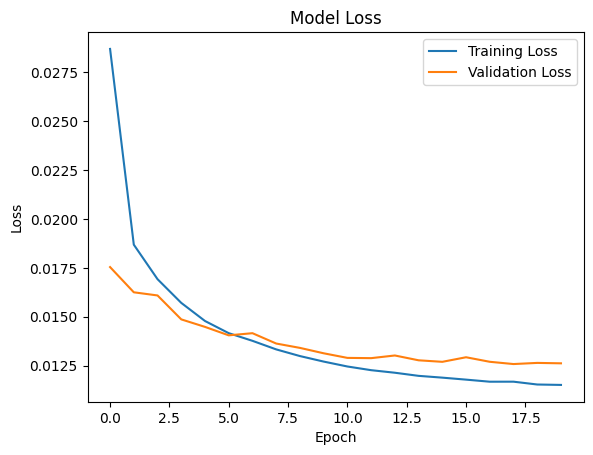

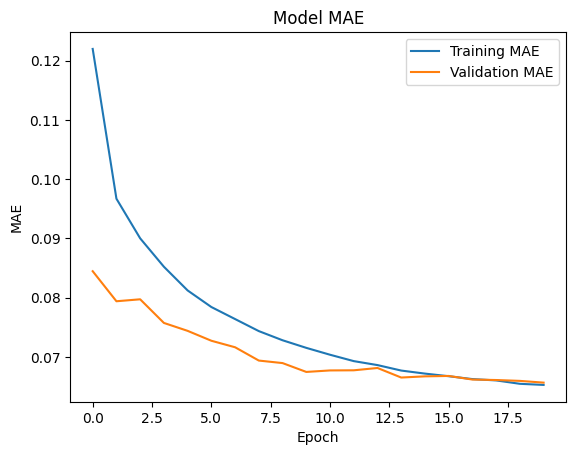

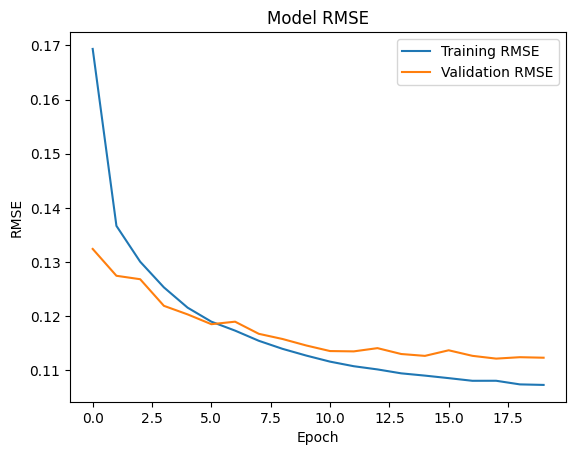

In [28]:
# График потерь
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

# График MAE
plt.plot(history.history['mean_absolute_error'], label='Training MAE')
plt.plot(history.history['val_mean_absolute_error'], label='Validation MAE')
plt.title('Model MAE')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

# График RMSE
plt.plot(history.history['root_mean_squared_error'], label='Training RMSE')
plt.plot(history.history['val_root_mean_squared_error'], label='Validation RMSE')
plt.title('Model RMSE')
plt.ylabel('RMSE')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()